# IELTS Essay Scoring Model Evaluation

This notebook evaluates and calibrates our IELTS essay scoring model, analyzing its performance and generating insights for the research paper.

## Key Objectives:
1. Calibrate model predictions to valid IELTS band range (0-9)
2. Calculate model accuracy metrics (MAE, R²)
3. Visualize prediction performance
4. Test adaptive feedback mechanism

In [9]:
# Cell 1 - imports & config
import os
import re
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import sentencepiece as spm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from scipy import stats
from tqdm import tqdm

# Adjust paths
project_root = "/home/mastermind/ielts_pred"
SPM_MODEL = os.path.join(project_root, "tokenizer", "spm.model")
model_path = "src/model/ielts_improved_model.pt"
data_path = "data/ielts_clean.csv"

MAX_SEQ_LEN = 200
EMBEDDING_DIM = 200
BATCH_SIZE = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


Device: cuda


## Load and Prepare Data

Let's load our IELTS dataset and prepare it for evaluation. We'll also initialize our model with the trained weights.

In [10]:
# Cell 2 - helpers (must match training!)
def extract_linguistic_features(essay):
    words = essay.split()
    sentences = re.split(r'[.!?]+', essay)
    sentences = [s.strip() for s in sentences if s.strip()]
    features = []
    features.append(len(words))
    features.append(len(sentences) if sentences else 1)
    features.append(len(words) / max(len(sentences), 1))
    unique_words = len(set(w.lower() for w in words))
    features.append(unique_words / max(len(words), 1))
    features.append(len(essay))
    features.append(sum(1 for c in essay if c.isupper()) / max(len(essay), 1))
    features.append(essay.count(',') / max(len(words), 1))
    features.append(essay.count('.') / max(len(sentences), 1))
    avg_word_len = sum(len(w) for w in words) / max(len(words), 1)
    features.append(avg_word_len)
    transition_words = {
        'however', 'moreover', 'furthermore', 'therefore', 'consequently',
        'nevertheless', 'additionally', 'specifically', 'particularly', 'especially'
    }
    transition_count = sum(1 for w in words if w.lower() in transition_words)
    features.append(transition_count / max(len(words), 1))
    return np.array(features, dtype='float32')

def tokenise_spm_with_mask(essays, max_len=MAX_SEQ_LEN):
    sp = spm.SentencePieceProcessor(model_file=SPM_MODEL)
    encoded, masks = [], []
    for e in essays:
        ids = sp.encode(e, out_type=int)[:max_len]
        mask = [1]*len(ids) + [0]*(max_len - len(ids))
        padded = ids + [0]*(max_len - len(ids))
        encoded.append(padded)
        masks.append(mask)
    return torch.tensor(encoded, dtype=torch.long), torch.tensor(masks, dtype=torch.long)


## Implement Prediction Function with Calibration

Now we'll create a function that makes predictions and ensures they stay within the valid IELTS band range (0-9).

In [12]:
# Cell 3 - load and split (NO AUGMENTATION for fair test)
from sklearn.model_selection import train_test_split
from src.utils.data import load_dataset, prepare_data
df = load_dataset(data_path)

# IMPORTANT: create a held-out test / validation using augment=False
train_df, val_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

print("Train / Val sizes:", len(train_df), len(val_df))
print(val_df['Overall'].value_counts().sort_index())


Loaded 1435 samples from data/ielts_clean.csv
Score range: 1.0 - 9.0
Train / Val sizes: 1219 216
Overall
3.5     1
4.0     3
4.5     5
5.0     9
5.5    31
6.0    43
6.5    34
7.0    42
7.5    17
8.0    19
8.5     6
9.0     6
Name: count, dtype: int64


## Evaluate Model Performance

Let's calculate key metrics (MAE, R²) and create visualizations to assess model performance.

In [13]:
# Cell 4 - tokenization & features for val set
X_val, X_val_mask = tokenise_spm_with_mask(val_df['Essay'].values)
val_features = np.array([extract_linguistic_features(e) for e in val_df['Essay'].values])

feat_mean = np.load(os.path.join(project_root, "features_mean.npy"))
feat_std  = np.load(os.path.join(project_root, "features_std.npy"))
X_val_feat = torch.tensor((val_features - feat_mean) / feat_std, dtype=torch.float32)

y_val_scaled = torch.tensor(val_df['Scaled'].values, dtype=torch.float32)
y_val_ielts = val_df['Overall'].values

print("X_val shape:", X_val.shape, "feat shape:", X_val_feat.shape)
val_dataset = TensorDataset(X_val, X_val_mask, X_val_feat, y_val_scaled)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

X_val shape: torch.Size([216, 200]) feat shape: torch.Size([216, 10])


## Visualize Results

Create scatter plots and comparison tables to visualize model performance.

In [14]:
# Cell 5 - load model
from src.model.transformer import IELTSTransformerWithFeatures

checkpoint = torch.load(model_path, map_location=device)
vocab_size = checkpoint['vocab_size']

model = IELTSTransformerWithFeatures(
    vocab_size=vocab_size, d_model=EMBEDDING_DIM, nhead=4, num_layers=3, max_len=MAX_SEQ_LEN, dropout=0.2
).to(device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded. Params:", sum(p.numel() for p in model.parameters()))

Model loaded. Params: 3020779


## Test Adaptive Feedback System

Let's test the feedback system with a sample essay, apply the suggested improvements, and measure the score change.

In [15]:
# Cell 6 - predict + core metrics
y_pred_scaled = []
y_true_scaled = []

with torch.no_grad():
    for xb, mask, feat, yb in val_loader:
        xb = xb.to(device); mask = mask.to(device); feat = feat.to(device)
        preds = model(xb, feat, mask).squeeze().cpu().numpy()
        y_pred_scaled.extend(preds)
        y_true_scaled.extend(yb.numpy())

y_pred_scaled = np.clip(np.array(y_pred_scaled), 0, 1)
y_true_scaled = np.array(y_true_scaled)
y_pred_ielts = y_pred_scaled * 9
y_true_ielts = y_val_ielts

mae = mean_absolute_error(y_true_ielts, y_pred_ielts)
rmse = np.sqrt(mean_squared_error(y_true_ielts, y_pred_ielts))
r2 = r2_score(y_true_ielts, y_pred_ielts)
pearson, _ = stats.pearsonr(y_true_ielts, y_pred_ielts)
spearman, _ = stats.spearmanr(y_true_ielts, y_pred_ielts)

print("MAE:", mae, "RMSE:", rmse, "R2:", r2, "Pearson:", pearson, "Spearman:", spearman)


MAE: 0.2651722166273329 RMSE: 0.4052652667150306 R2: 0.8529640511764386 Pearson: 0.9337910025745522 Spearman: 0.9303386062013009


## Summary for Research Paper

Key findings and metrics for your research paper.

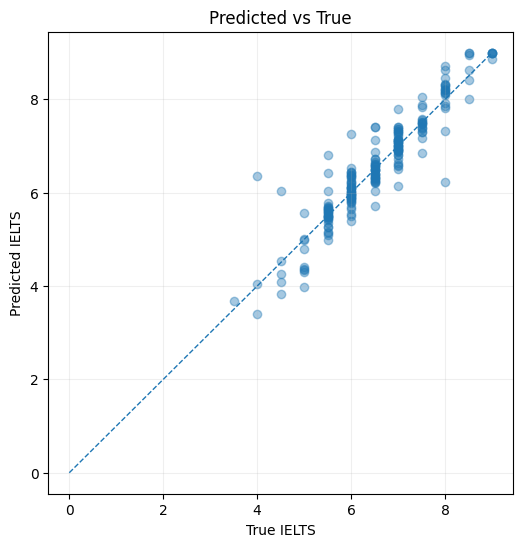

In [16]:
# Cell 7 - scatter predicted vs true
plt.figure(figsize=(6,6))
plt.scatter(y_true_ielts, y_pred_ielts, alpha=0.4)
plt.plot([0,9],[0,9], '--', linewidth=1)
plt.xlabel("True IELTS")
plt.ylabel("Predicted IELTS")
plt.title("Predicted vs True")
plt.grid(alpha=0.2)
plt.show()


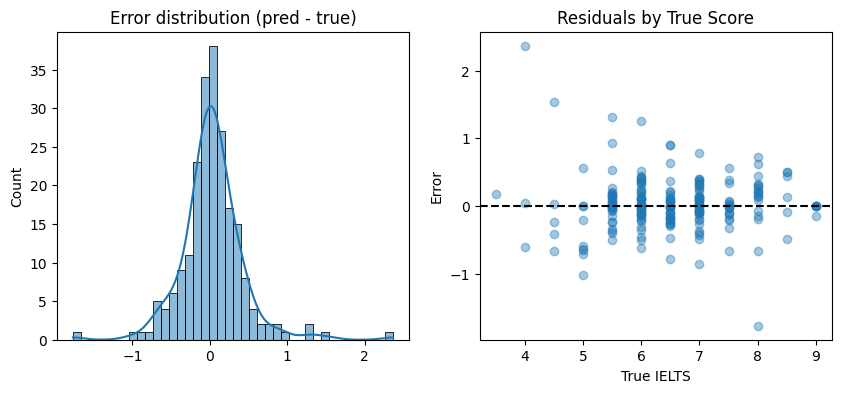

In [17]:
# Cell 8 - residuals / histogram
errors = y_pred_ielts - y_true_ielts
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(errors, bins=40, kde=True)
plt.title("Error distribution (pred - true)")

plt.subplot(1,2,2)
plt.scatter(y_true_ielts, errors, alpha=0.4)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("True IELTS")
plt.ylabel("Error")
plt.title("Residuals by True Score")
plt.show()


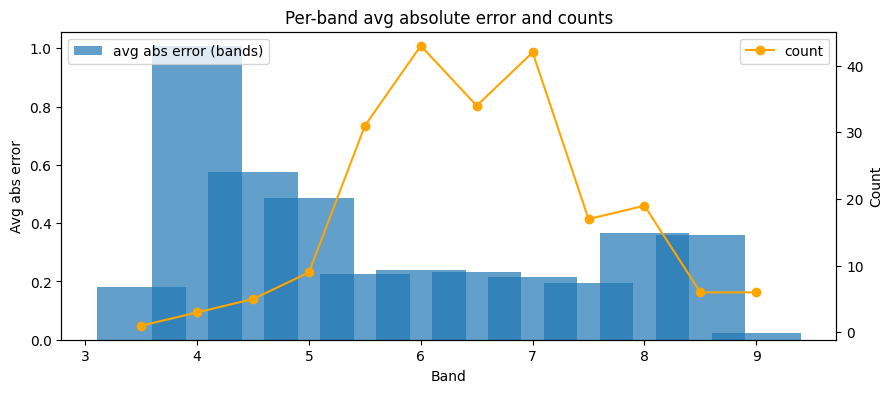

In [18]:
# Cell 9 - per-band average error & counts
bands = sorted(set(y_true_ielts))
avg_errors = []
counts = []
for b in bands:
    mask = y_true_ielts == b
    avg_errors.append(np.mean(np.abs(errors[mask])))
    counts.append(np.sum(mask))

fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()
ax1.bar(bands, avg_errors, alpha=0.7, label='avg abs error (bands)')
ax2.plot(bands, counts, color='orange', marker='o', label='count')
ax1.set_xlabel("Band")
ax1.set_ylabel("Avg abs error")
ax2.set_ylabel("Count")
ax1.set_title("Per-band avg absolute error and counts")
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
plt.show()


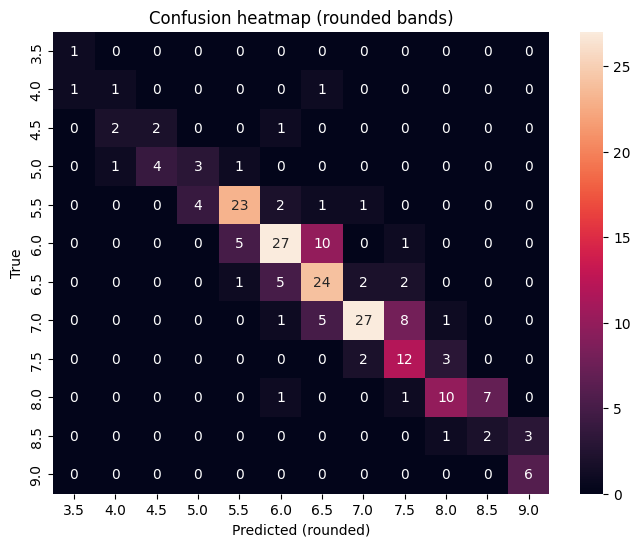

In [21]:
# Cell 10 - confusion heatmap (rounded to 0.5 bands)
y_pred_round = np.round(y_pred_ielts * 2)/2
unique_bands = sorted(list(set(np.concatenate([y_true_ielts, y_pred_round]))))
cm = confusion_matrix(
    y_true_ielts.astype(str),
    y_pred_round.astype(str),
    labels=[str(b) for b in unique_bands]
)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_bands, yticklabels=unique_bands)
plt.xlabel("Predicted (rounded)")
plt.ylabel("True")
plt.title("Confusion heatmap (rounded bands)")
plt.show()


In [22]:
# Cell 11 - bootstrap CI function and display
def bootstrap_metric(y_true, y_pred, metric_fn, n_bootstrap=1000):
    rng = np.random.default_rng(42)
    metrics = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, n)
        metrics.append(metric_fn(y_true[idx], y_pred[idx]))
    return np.percentile(metrics, 2.5), np.percentile(metrics, 97.5)

mae_ci = bootstrap_metric(y_true_ielts, y_pred_ielts, mean_absolute_error, 1000)
r2_ci = bootstrap_metric(y_true_ielts, y_pred_ielts, r2_score, 1000)
print("MAE CI:", mae_ci, "R2 CI:", r2_ci)


MAE CI: (0.22678062341831348, 0.30557541436067337) R2 CI: (0.7827913043679223, 0.9037297240856398)
